Balanced data distribution:
stance_label
neutral    3725
against     800
for         800
Name: count, dtype: int64
Accuracy: 0.9877934272300469

Classification Report:
               precision    recall  f1-score   support

     against       0.98      0.96      0.97       160
         for       0.99      0.98      0.99       160
     neutral       0.99      0.99      0.99       745

    accuracy                           0.99      1065
   macro avg       0.99      0.98      0.98      1065
weighted avg       0.99      0.99      0.99      1065



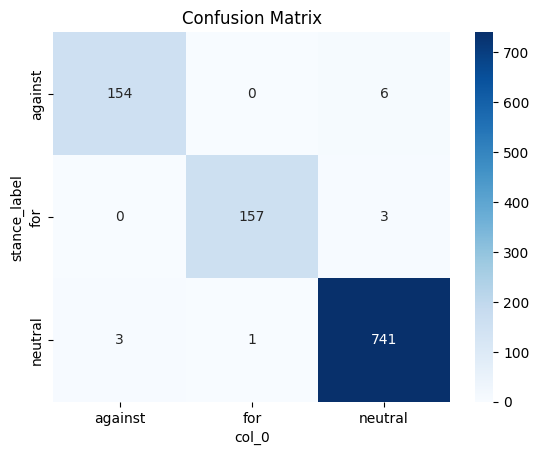

Model saved as stance_model_balanced.joblib


In [11]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ===========================
# LOAD CLEANED DATA
# ===========================
df = pd.read_csv(r"C:\Users\Ayush Ahlawat\OneDrive\Documents\Public Comment Analysis\public-comment-analysis\dataset\final_cleaned_dataset.csv")

# ===========================
# OVERSAMPLING STEP
# ===========================
df_for = df[df.stance_label == "for"]
df_against = df[df.stance_label == "against"]
df_neutral = df[df.stance_label == "neutral"]

df_for_up = resample(df_for, replace=True, n_samples=800, random_state=42)
df_against_up = resample(df_against, replace=True, n_samples=800, random_state=42)

balanced_df = pd.concat([df_for_up, df_against_up, df_neutral], axis=0)
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

print("Balanced data distribution:")
print(balanced_df["stance_label"].value_counts())

X = balanced_df["comment_text"].astype(str)
y = balanced_df["stance_label"].astype(str)

# ===========================
# SENTIMENT FEATURE
# ===========================
class SentimentExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        out = []
        for text in X:
            s = self.vader.polarity_scores(text)
            out.append([s["neg"], s["neu"], s["pos"], s["compound"]])
        return np.array(out)

# ===========================
# MODEL PIPELINE
# ===========================
pipeline = Pipeline([
    ("features", FeatureUnion([
        ("tfidf", TfidfVectorizer(max_features=7000, ngram_range=(1,2), stop_words="english")),
        ("sentiment", SentimentExtractor())
    ])),
    ("clf", LogisticRegression(max_iter=4000, class_weight="balanced", C=2.5))
])

# ===========================
# TRAIN TEST SPLIT
# ===========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ===========================
# TRAIN + EVALUATE
# ===========================
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(pd.crosstab(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()

joblib.dump(pipeline, "stance_model_balanced.joblib")
print("Model saved as stance_model_balanced.joblib")


In [14]:
def predict_stance(text):
    pred = pipeline.predict([text])[0]
    conf = pipeline.predict_proba([text]).max() * 100
    return pred, round(conf, 2)


# Demo
print("\n🔮 Example Prediction:")
sample = "good policy but modifications required"
print(predict_stance(sample))


🔮 Example Prediction:
('neutral', np.float64(71.33))
